In [1]:
from dataset import *

In [2]:
dataset = CommaDataset(BASE_DIR, N_FRAMES, cache=False, read_from_cache=True)
print(len(dataset))

[~] Initializing val dataset


11/11 - 18177: 100%|██████████| 11/11 [00:00<00:00, 233.15it/s]

[*] Dataset indices: [52721, 111713, 131443, 187608, 213472, 298767, 377229, 407766, 459456, 504247, 522423]
[*] Dataset length: 522434
[*] Steering angles (522434,) - Speeds (ms) (522434,)
[~] Initializing sequences
[+] Built 522369 sequences
[~] Initializing state values
[+] Dataset initialized
522369


In [3]:
import psutil
from torch.utils.data import DataLoader
from config import *

N_WORKERS = psutil.cpu_count(logical=False)
PREFETCH_FACTOR = psutil.cpu_count(logical=False) // 2

dataloader = DataLoader(
  dataset, batch_size=BATCH_SIZE, shuffle=True,
  prefetch_factor=PREFETCH_FACTOR, num_workers=N_WORKERS, pin_memory=False
)

In [4]:
from tqdm import tqdm

def get_logs(dataloader):
  steers, speeds = [], []
  for i_batch, sample_batched in enumerate((t := tqdm(dataloader))):
    steer = sample_batched["angle_steers"]
    speed = sample_batched["speed_ms"]
    # print(steer.shape, speed.shape)

    steers.append(steer)
    speeds.append(speed)

  steers = torch.cat(steers, dim=0).numpy()
  speeds= torch.cat(speeds, dim=0).numpy()
  return steers, speeds


In [5]:
steers, speeds = get_logs(dataloader)

100%|██████████| 8163/8163 [11:38<00:00, 11.69it/s]


In [6]:
steers

array([598.6773  , -40.4408  ,  -5.      , ..., -18.89183 ,  -9.      ,
       -43.800766], dtype=float32)

In [7]:
speeds

array([ 1.6419034,  6.40645  ,  5.1185017, ..., 29.612812 , 14.995558 ,
       23.566645 ], dtype=float32)

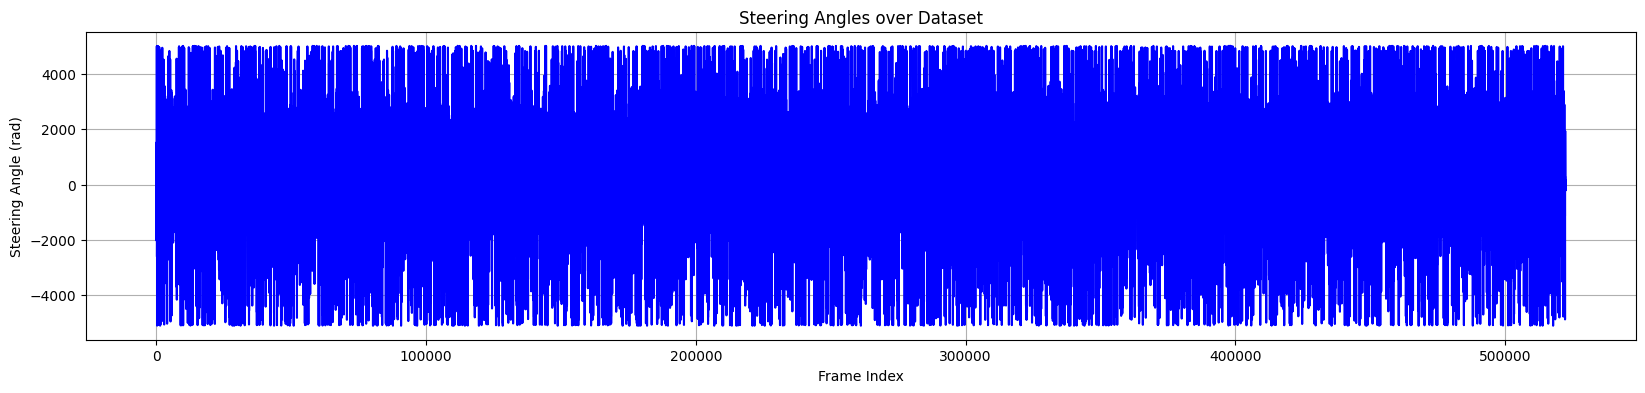

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 4))
plt.plot(steers, color='blue')
plt.title("Steering Angles over Dataset")
plt.xlabel("Frame Index")
plt.ylabel("Steering Angle (rad)")
plt.grid(True)
plt.show()

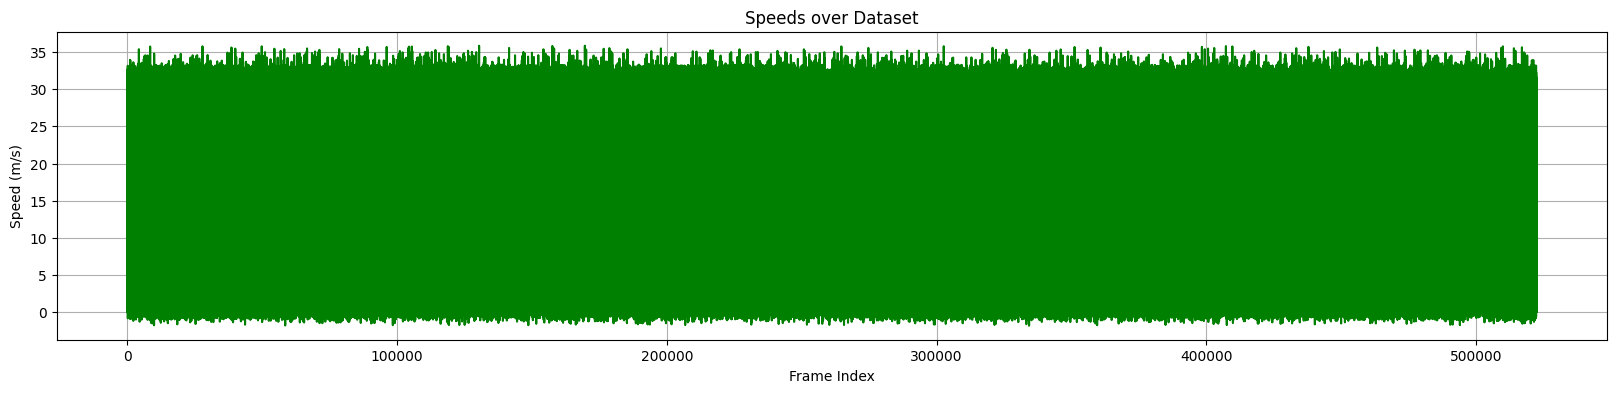

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 4))
plt.plot(speeds, color='green')
plt.title("Speeds over Dataset")
plt.xlabel("Frame Index")
plt.ylabel("Speed (m/s)")
plt.grid(True)
plt.show()


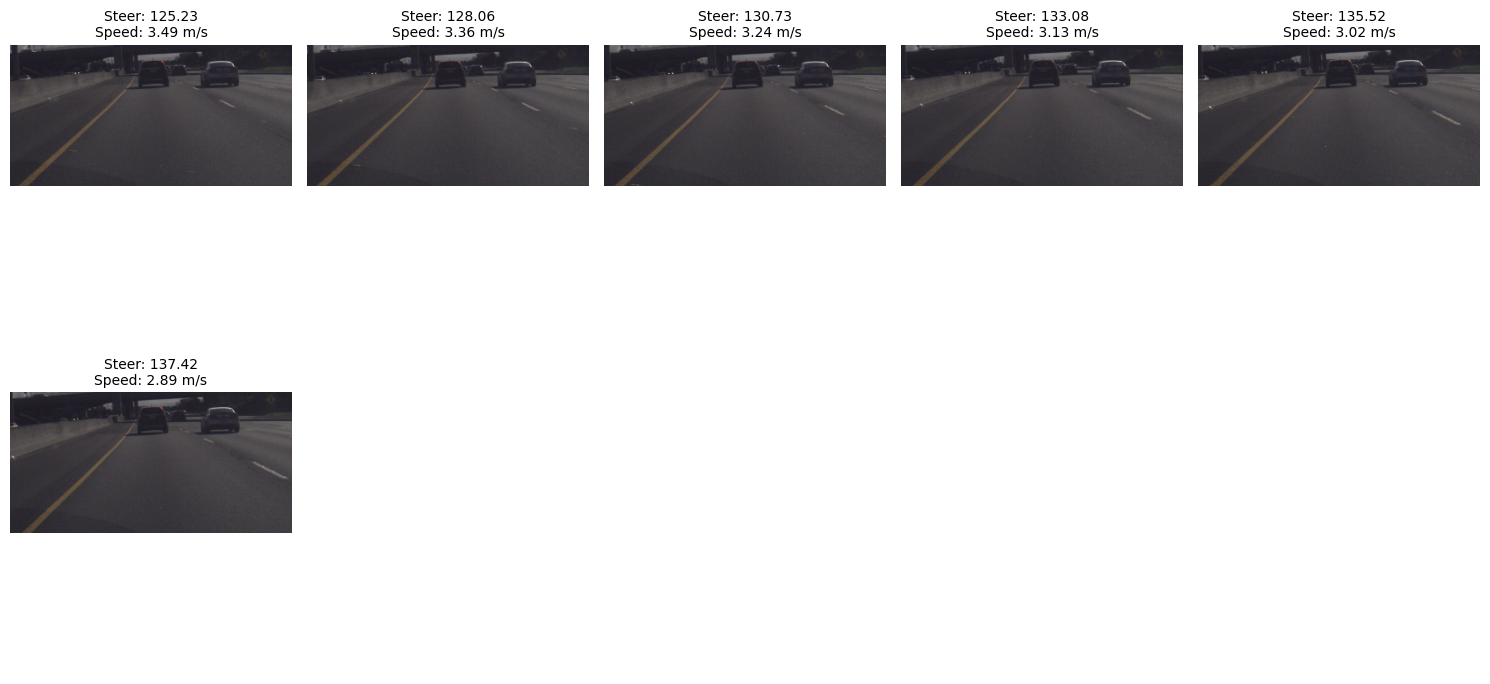

In [14]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# ImageNet mean/std for denormalization
mean = np.array(IMAGENET_MEAN).reshape(3,1,1)
std = np.array(IMAGENET_STD).reshape(3,1,1)

def denormalize(tensor):
    """
    tensor: (C,H,W)
    returns: HWC uint8
    """
    img = tensor.numpy() * std + mean
    img = np.clip(img, 0, 1)
    img = (img * 255).astype(np.uint8)
    return np.transpose(img, (1,2,0))  # HWC

# Get one batch
batch = next(iter(dataloader))
seq_frames = batch["seq_frames"][0]  # (seq_len, C, H, W)
next_frame = batch["next_frame"][0]  # (1, C, H, W)
dataset_idx, start_idx = dataset.sequences[1500]  # index of this sequence in dataset

# Gather all frames
all_frames = torch.cat([seq_frames, next_frame], dim=0)  # (seq_len+1, C, H, W)

# Get logs for each frame
frame_indices = [dataset._global_idx(dataset_idx, start_idx + i) for i in range(all_frames.shape[0])]
steers = dataset.steers[frame_indices]
speeds = dataset.speeds[frame_indices]

# Plot grid
seq_len_plus = all_frames.shape[0]
cols = min(seq_len_plus, 5)
rows = (seq_len_plus + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*4))
axes = axes.flatten()

for i in range(seq_len_plus):
    img = denormalize(all_frames[i])
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Steer: {steers[i]:.2f}\nSpeed: {speeds[i]:.2f} m/s", fontsize=10)

# Hide any extra axes
for i in range(seq_len_plus, len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()
